# 心血管疾病预测

*平台上训练可能比较慢，你可以从[这里](https://isrc.iscas.ac.cn/gitlab/summer2020/students/proj-2033168/-/blob/master/predict.ipynb)得到每个单元的输出，也可以在 [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/LovelyBuggies/Python_Cardiovascular_Disease_Predict/master?filepath=predict.ipynb) 上发布以训练。*

## 背景

心血管疾病是一种严重威胁人类，特别是中老年人健康的常见病，具有高患病率、高致残率和高死亡率的特点，即使应用目前最先进、完善的治疗手段，仍有许多心血管意外幸存者生活不能完全自理，全世界每年死于心血管疾病的人数高达 1500 万人，居各种死因首位。

近年来，神经网络等深度学习的技术正逐渐应用于临床和诊断。逐渐丰富的数据集能够帮助我们根据对患者记录的统计进行数据分析来预测心血管疾病的患病情况。在分类问题中，分类的目的是从一组数据中选择一个类别（例如，给出一张苹果或橘子的图片，并确定图片中的水果是什么）。本项目使用心血管疾病数据集，该数据集提供 11 个特征值和 1 个目标值，包含 70,000 例患者记录的数据，建立了预测样本是否有心血管疾病的算法模型。最终的预测结果被证明有较高的准确性，说明了将深度学习算法应用于疾病尤其是心血管疾病检测的潜力。

## 数据预处理

数据的预处理是指对所收集数据进行分类或分组前所做的审核、筛选、排序等必要的处理。数据预处理技术是为了提高数据分析的质量而产生的，方法包括数据清理、数据集成、数据变换，数据归约等。

我们首先从 Kaggle 数据集 https://www.kaggle.com/sulianova/cardiovascular-disease-dataset 中下载数据，并将数据放到合适的文件夹以供加载。然后我们对数据进行了简单的处理。

### 数据探索

在进行心血管疾病预测之前，我们首先探索一下该数据集的数据特征。

In [1]:
# 导入相关依赖包
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

用 pandas 读取数据集，并显示数据项类型。

In [2]:
data = pd.read_csv("./data/cardio_train.csv", sep=";")
# 展示数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


让我们看一下每一项数据是怎样的。

In [3]:
# 将年龄单位转化成年
data['age'] = data['age'].map(lambda x : x // 365)

data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


每一项数据中，含有的指标包含:

1. `age` —— 年龄/岁；
2. `gender` —— 性别：1-女，2-男；
3. `height` —— 身高/厘米；
4. `weight` —— 体重/公斤；
5. `ap_hi` —— 收缩压/mmHg；
6. `ap_lo` —— 舒张压/mmHg；
7. `cholesterol` —— 胆固醇水平：1-正常，2-略高，3-过高（正常2.9～5.8mmol/L）；
8. `gluc` —— 血糖水平：1-正常，2-略高，3-过高（正常3.9～6.1mmol/L）；
9. `smoke` —— 是否吸烟：0-否，1-是；
10. `alco` —— 是否饮酒：0-否，1-是；
11. `active` —— 是否活动：0-否，1-是；

以及心血管疾病患病结果 `cardio` —— 是否患病：0-否，1-是。

### 数据预处理

为了方便我们分析数据，我们进行了数据清理——剔除数据中的无效值也就是血压过高或者过低的值，脏数据和空项 NULL（如果有的话）。

In [4]:
# 检查数据中是否含有空项
print(data.isnull().values.any())

# 检查数据中是否含有脏数据-以吸烟为例
print(1 >= data['smoke'].values.all() >= 0)

False
True


数据集中没有空项和脏数据，因此不必剔除。

In [5]:
if "id" in data:
    data.drop("id",axis=1,inplace=True)

data.drop_duplicates(inplace=True)

# 将血压过高或者过低的异常值剔除
out_lier = (data["ap_hi"] > 250) | (data["ap_lo"] > 200) | (data["ap_hi"] < 0) | (data["ap_lo"] < 0)
data = data[~out_lier]

# 展示经过数据预处理之后的信息
# data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65791 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          65791 non-null  int64  
 1   gender       65791 non-null  int64  
 2   height       65791 non-null  int64  
 3   weight       65791 non-null  float64
 4   ap_hi        65791 non-null  int64  
 5   ap_lo        65791 non-null  int64  
 6   cholesterol  65791 non-null  int64  
 7   gluc         65791 non-null  int64  
 8   smoke        65791 non-null  int64  
 9   alco         65791 non-null  int64  
 10  active       65791 non-null  int64  
 11  cardio       65791 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.5 MB


剔除异常值之后，我们的数据集中减少了 1025 个表项。

### 数据可视化

数据可视化主要旨在借助于图形化手段，清晰有效地传达与沟通信息。良好的数据展示能够方便我们更高效地进行数据分析。我们可以绘制每一个特征的数值分布直方图和折线图来将我们的数据集可视化。

首先我们将患病者的信息提取出来，并绘制数据集中患病者的和所有的特征数值分布直方图（分别用红色和蓝色表示）。

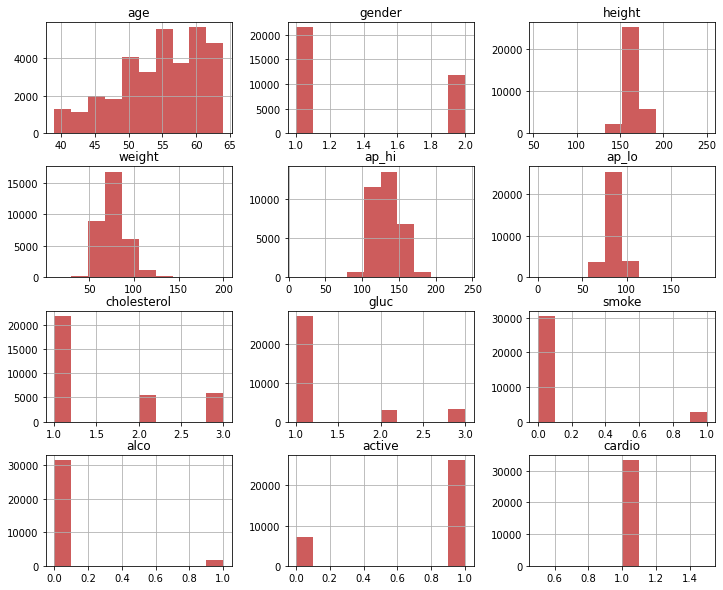

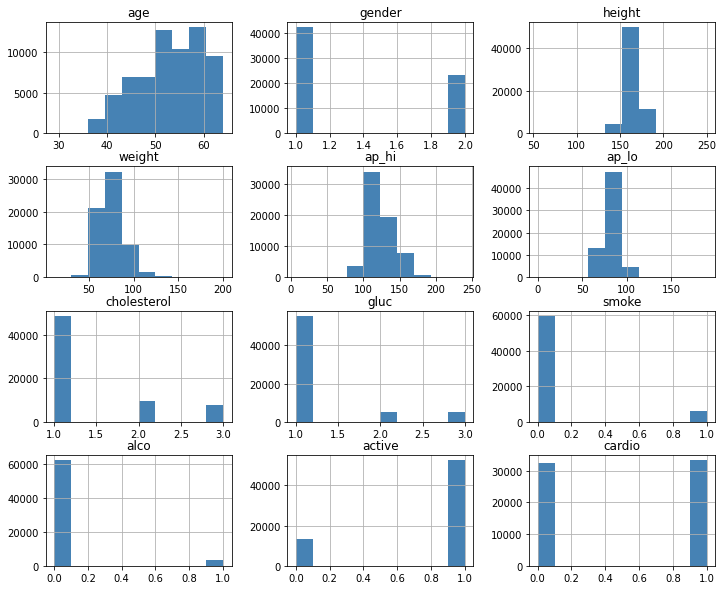

In [6]:
# 提取出来患病者的指标信息
cardio = data.loc[data['cardio'] == 1]

# 绘制特征数值分布直方图

cardio.hist(figsize=(12,10), color='indianred')
data.hist(figsize=(12,10), color='steelblue')
plt.show()

通过直方图，我们可以得到一些结论，比如：通过观察患病者的 `age` 直方图，我们可以看到，高年龄组是心血管疾病的高危人群。

但是我们并不能草率的根据这个直方图得到结论，因为现实生活中，每种指标的人口基数是不同的（比如抽烟的人占少数、大部分人都运动等），数据集中的统计表项可能也不能包罗各种情况（比如其他生理指标引起的心血管疾病），因此这些直观观察结论只能作为参考。

我们还可用箱线图表示出来数据集中各种非0-1指标的统计数值波动。

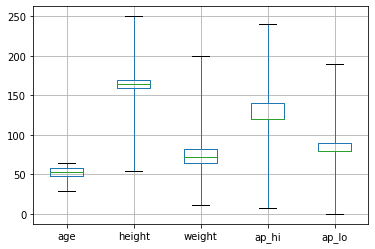

In [7]:
# 绘制特征数值分布箱线图
data[['age','height', 'weight','ap_hi','ap_lo']].boxplot(whis=10)
plt.show()

上图展示了每个指标的数值分布箱线图，其中我们调节了 `whis` 变量，排除数据预处理之后的所有离群值。我们可以清晰地看到每个指标的中位数，四分位数和极值，分别是箱子中的绿线、箱子的两条蓝色横边和首尾的两条黑色横边。因为每个变量量纲不同，我们只能各自观测，不能横向比较。但是对比舒张压和收缩压，我们可以发现，收缩压的波动范围更小一些。

### 相关性分析

因为很多指标可能是高度关联的，高维度的处理运算量大，会比较困难，接下来我们尝试使用 Seaborn 工具进行不同指标相关性的分析，减少不必要运算。Seaborn 是一个基于 matplotlib 的 Python 数据可视化库。它提供了一个高级界面，以绘制信息统计图形。

我们先用 Seaborn 的 `pairplot` 在数据集中绘制成对关系，进行指标之间的相关性展示。

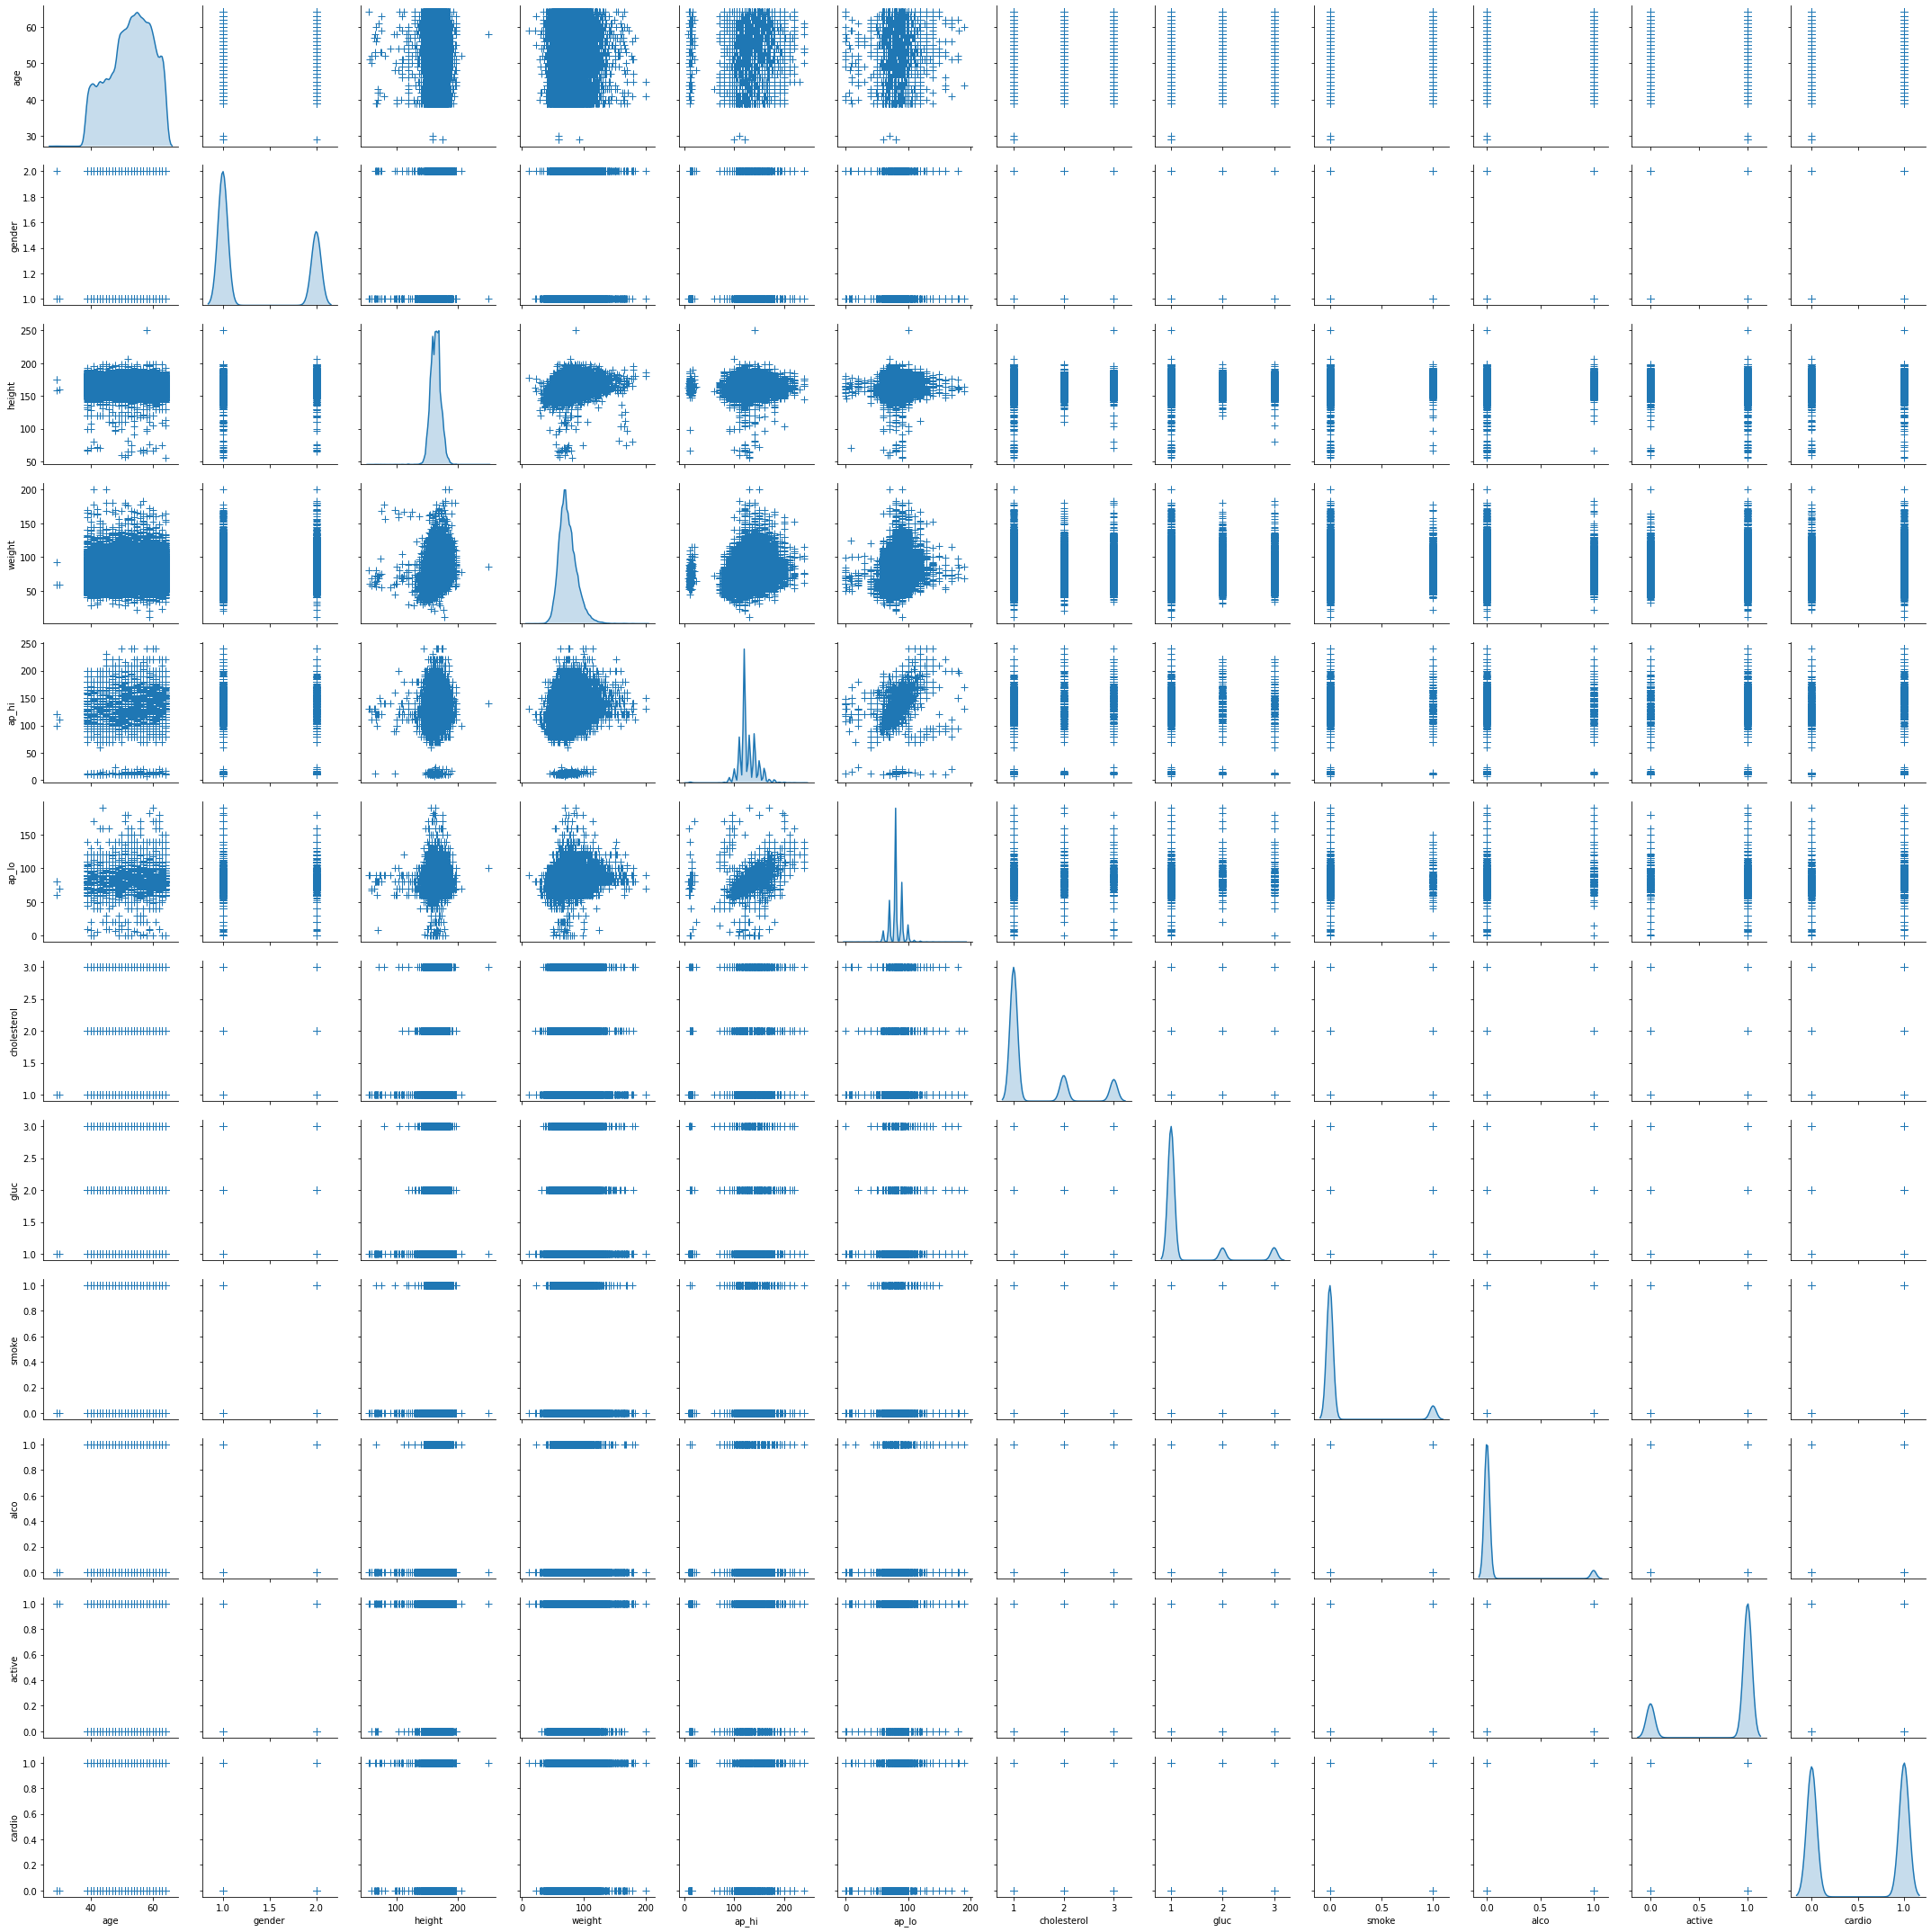

In [8]:
import seaborn as sns

sns_plot = sns.pairplot(data=data, diag_kind="kde", markers="+",
                              plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                              diag_kws=dict(shade=True))

在 `pairplot` 中，相关性强的变量之间的 `pairplot` 应该大致呈线性递增或递减的，而从图中，我们可以看出，该数据集中大部分的 `pairplot` 呈如下所示的分布，是随机的或者无关联的：

![](https://tva1.sinaimg.cn/bmiddle/007S8ZIlgy1gix8j20qd1j30lg05udga.jpg)

因此，对于这个数据集，我们可以不进行降维。

为了更加精确地阐述各个指标之间的关系，我们用 numpy 的相关性计算得到不同指标之间的相关性。然后我们用 `heatmap` 展示具体的相关性数值。

*值得注意的是，这种方法利用皮尔逊积矩相关系数进行相关性计算：*

![](https://numpy.org/doc/stable/_images/math/a045c86ccf4a52d7c8618a55e96c7076b6ebfe74.svg)

*你也可以选择其他方法。*

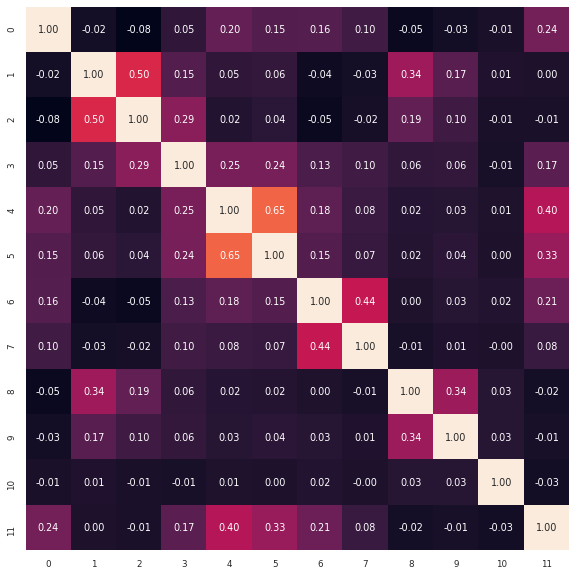

In [9]:
cm = np.corrcoef(data.values.T)   
sns.set(font_scale=.8)
plt.figure(figsize=(10,10))
sns.heatmap(cm,cbar=False,annot=True,square=True,fmt='.2f')
plt.show()

`pairplot` 中越相关（呈线形）的关系在 `corrcoef` 中越“热”。对角线上表示自反关系，所以都是 1.00 。

我们发现，大部分相关性都是在 0 附近，因此没有很强的正相关和负相关。相关性最强的是第五个和第六个变量，也就是收缩压和舒张压，因为它们都属于血压的范畴。因为它们关联性不是极强，并且血压指标可能对心血管疾病有很重要的影响，因此在此我们没有整合它们。

除此之外，我们发现其实第二个变量和第三个变量相关性依然也比较强，这个结论很直观，因此男性往往比女性要高。有趣的是，身高和体重的正相关关系在该数据集中并没有体现得很明显。

### 分离数据

我们现有的数据都在一个 csv 文件中，我们需要分离数据以得到训练集和验证集。

我们现将标签和真值分离出来。然后，我们使用了 `sklearn.model_selection` 中的分离函数，设置分离比率为 9 比 1，分离之后训练集中还有 62077 个项，验证集中含有 6898 个项。

*注意：验证集是模型训练过程中单独留出的样本集，它可以用于调整模型的超参数和用于对模型的能力进行初步评估；而测试集是用来评估模最终模型的泛化能力。但不能作为调参、选择特征等算法相关的选择的依据。这里我们根据最后的模型准确率进行调参，因此称之为验证集。*

In [10]:
# 将 labels 从 data 中提取出来
labels = data['cardio']
data = data.drop(['cardio'], axis=1)

In [11]:
from sklearn.model_selection import train_test_split

# 分离数据集
train, valid, train_labels, ground_truth = train_test_split(data, labels, test_size=0.1, random_state=0)

# 分别展示训练集和验证集的数据
train.info()
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59211 entries, 30867 to 45734
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59211 non-null  int64  
 1   gender       59211 non-null  int64  
 2   height       59211 non-null  int64  
 3   weight       59211 non-null  float64
 4   ap_hi        59211 non-null  int64  
 5   ap_lo        59211 non-null  int64  
 6   cholesterol  59211 non-null  int64  
 7   gluc         59211 non-null  int64  
 8   smoke        59211 non-null  int64  
 9   alco         59211 non-null  int64  
 10  active       59211 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 5.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6580 entries, 28539 to 50252
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          6580 non-null   int64  
 1   gender       6580 non-null   int64  
 2   heigh

*补充：尽管我们在训练前提出了训练集和验证集，但是这一步也可以在训练时进行，在 `model.fit` 时，我们可以设置 `validation_split` 参数分离数据集。*

## 深度学习模型

神经网络是一种比标准机器学习更复杂、更强大的算法，属于深度学习模型。Keras 是一个开源人工神经网络库，可以作为 Tensorflow、Microsoft-CNTK 和 Theano 的高阶应用程序接口，进行深度学习模型的设计、调试、评估、应用和可视化。在这里，我们用 Keras 搭建一个顺序神经网络，并训练好的网络进行心血管疾病预测。

In [12]:
# 导入相关依赖包
import keras
from keras.models import Sequential, Input
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import metrics

### 全连接神经网络

#### 构建模型

Keras 的顺序模型适用于每一层有一个输入张量和一个输出张量的普通层堆栈。在构建新的顺序体系结构时，使用 `add` 递增地堆叠层并经常打印模型是一种常用的构建和 debug 神经网络的方法：

In [13]:
# 构建神经网络顺序模型
model = Sequential()

# 为模型增加全连接层
model.add(Dense(16, input_dim=data.shape[1], kernel_initializer='random_uniform', activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(64, kernel_initializer='random_uniform', activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(32, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 打印模型
# model.layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
______________________________________________________

#### 模型解释

`Dense` 就是常提到和用到的全连接层，相当于简单的特征加权 。`Dense` 实现的操作为：`output = activation(dot(input, kernel) + bias)` 其中 `activation` 是按逐个元素计算的激活函数，`kernel` 是由网络层创建的权值矩阵，以及 `bias` 是其创建的偏置向量（*我们这里没有用偏置*）。构建神经网络模型的时候，我们首先先添加一个 `Dense` 层，输入的维度是训练集的列数也就是特征数；之后，我们就不必定义 `input` 规格了。

因为不同特征的数值差别可能很大，我们需要进行正则化处理。Keras 中，我们可以使用 `Dopout` 正则化，其最简单的 `Dopout` 形式是`Dropout` 核心层。在创建 `Dopout` 正则化时，可以将 `dropout_rate` 的设为某一固定值，当 `dropout_rate=0.7` 时，实际上保留概率为 0.3。将 `Dropout` 层添加到模型的现有层和之前的输出层之间，神经网络将这些输出反馈到后续层中。

#### 训练模型

对刚才构建好的神经网络进行训练。我们采用交叉熵作为损失函数，Adam 作为优化器进行模型编译。

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

模型拟合时，我们先将批大小设置为 64（*通常而言，批量越少，训练越慢，但是单次得到的训练更准确*），简单训练 20 个 epoch，并将每次训练的结果记录下来。

In [15]:
hist = model.fit(train, train_labels, batch_size=64, validation_data=(valid, ground_truth), 
               epochs=20, verbose=1)

Epoch 1/20
926/926 [==============================] - 2s 2ms/step - loss: 0.6717 - accuracy: 0.5741 - val_loss: 0.6313 - val_accuracy: 0.6667
Epoch 2/20
926/926 [==============================] - 2s 2ms/step - loss: 0.6610 - accuracy: 0.5972 - val_loss: 0.6276 - val_accuracy: 0.7052
Epoch 3/20
926/926 [==============================] - 2s 2ms/step - loss: 0.6506 - accuracy: 0.6215 - val_loss: 0.6235 - val_accuracy: 0.6916
Epoch 4/20
926/926 [==============================] - 2s 2ms/step - loss: 0.6483 - accuracy: 0.6212 - val_loss: 0.6189 - val_accuracy: 0.6982
Epoch 5/20
926/926 [==============================] - 2s 2ms/step - loss: 0.6462 - accuracy: 0.6253 - val_loss: 0.6286 - val_accuracy: 0.6810
Epoch 6/20
926/926 [==============================] - 2s 2ms/step - loss: 0.6475 - accuracy: 0.6230 - val_loss: 0.6182 - val_accuracy: 0.6824
Epoch 7/20
926/926 [==============================] - 2s 2ms/step - loss: 0.6468 - accuracy: 0.6230 - val_loss: 0.6175 - val_accuracy: 0.7103
Epoch 

我们将训练过程中的准确率和损失变化展示出来。

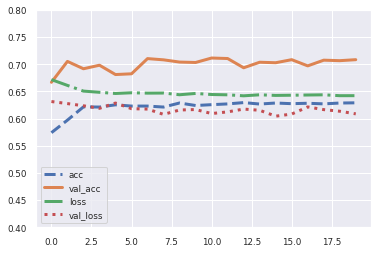

In [16]:
plt.plot(hist.history['accuracy'], label='acc', lw=3, ls='--')
plt.plot(hist.history['val_accuracy'], label='val_acc', lw=3, ls='-')
plt.plot(hist.history['loss'], label='loss', lw=3, ls='-.')
plt.plot(hist.history['val_loss'], label='val_loss', lw=3, ls=':')
plt.ylim((.4, .8))
plt.legend()
plt.show()

我们发现，随着模型训练，训练集和验证集的损失都在呈现减小的趋势，而准确率在随之提升。并且，模型在很早的 epoch 时就开始收敛了。收敛时，训练集波动很小，而验证集呈现更大波动。说明在该批量下，我们可以减少训练周期以提升训练效率。

#### 模型评估

为了衡量我们模型的好坏，我们首先将我们的预测结果与真实结果做了对比。因为我们得到的是患病概率，我们将结果简单地进行二值化处理，然后与真实值比较，可以得到训练集和验证集的预测准确率：

In [17]:
# 训练集预测结果
prediction = model.predict(train) 
prediction = (prediction > 0.5) * 1

# 计算准确率
acc_ann = round(metrics.accuracy_score(train_labels, prediction) * 100, 2)
acc_ann

70.89

In [18]:
# 验证集预测结果
prediction_valid = model.predict(valid)
prediction_valid = (prediction_valid > 0.5) * 1
# 计算准确率
acc_valid_ann = round(metrics.accuracy_score(ground_truth, prediction_valid) * 100, 2)
acc_valid_ann

70.84

本次训练，我们得到了训练集和验证集准确率都在 70% 左右（*注意，随着数据集划分不同，每次的结果可能也不同*）。

我们将预测结果可视化出来。

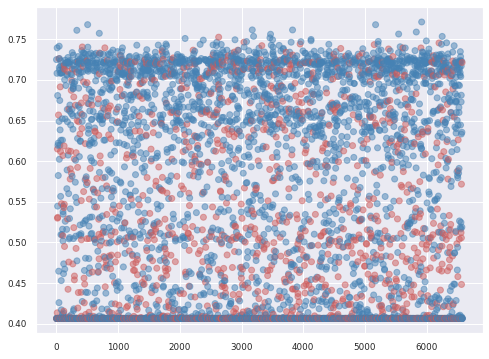

In [19]:
plt.figure(figsize=(8,6))

# 得到预测结果
prediction_valid = model.predict(valid)
prediction_flat = list(np.concatenate(prediction_valid).flat)

# 计算预测结果正确与否
color = [
    'steelblue' if ground_truth.to_list()[i] == (prediction_valid[i] > 0.5) * 1 
    else 'indianred' 
    for i in range(len(prediction_valid))
]

# 绘制散点图
plt.scatter(range(len(prediction_flat)), prediction_flat, c=color, alpha=0.5)
plt.show()

散点图中，横坐标表示样本的序号，纵坐标表示预测的患病概率。蓝色点代表正确的预测，红色点表示错误的预测。可以发现，大部分正确的预测都集中在两头，而错误预测大部分集中在中间。说明当特征明显预测患病或不患病概率明显时，能得到正确结论的概率比较高。

#### 模型调参

为了训练出更好的模型，我们需要找到最合适的参数。一个直观的办法就是遍历所有的参数可能性。以尝试不同的优化器和损失函数为例，我们将遍历一些常用到的优化器和损失函数：

In [20]:
# 先将上面的模型删除
del model

In [21]:
# 构建神经网络
def build_model(dropout_rate):
    model = Sequential()

    model.add(Dense(16, input_dim=data.shape[1], kernel_initializer='random_uniform', activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(64, kernel_initializer='random_uniform', activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(32, kernel_initializer='random_uniform', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [22]:
# 训练神经网络
def train_model(model, loss_func, optimizer, batch_size, epochs):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=['accuracy'])
    return model.fit(train, train_labels, batch_size=batch_size, validation_data=(valid, ground_truth), 
                   epochs=epochs, verbose=0)

为了减少训练时间，这里只是展示了常用的两种损失函数和三种优化器的训练情况。

In [23]:
# 参数候选者
dropout_rate = 0.7
epochs = 10
batch_size = 64
loss_funcs = ['binary_crossentropy', 'categorical_crossentropy']
optimizers = ['adam', 'sgd', 'rmsprop']
all_hist = []
all_models = []

# 构建和训练模型
for loss_func in loss_funcs:
    for optimizer in optimizers:
        # 重新构建模型
        model = build_model(dropout_rate)
        # 训练新模型并记录
        all_hist.append(train_model(model, loss_func, optimizer, batch_size, epochs))
        # 记录模型
        all_models.append(model)

我们可以利用 matplotlib 库直观展示上面的不同参数下的模型训练结果：

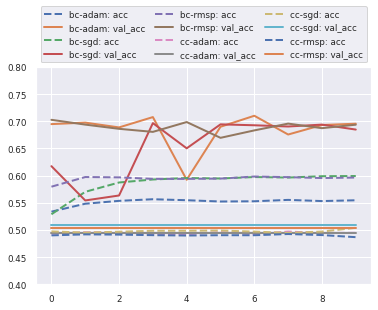

In [24]:
# 设置训练折线图的标签
labels = [
    'bc-adam', 
    'bc-sgd',
    'bc-rmsp',
    'cc-adam', 
    'cc-sgd', 
    'cc-rmsp',
]

for i, hist in enumerate(all_hist):
    # 绘制两个数据集的准确率变化
    prefix = labels[i] + ': '
    plt.plot(hist.history['accuracy'], label=prefix+'acc', lw=2, ls='--', )
    plt.plot(hist.history['val_accuracy'], label=prefix+'val_acc', lw=2, ls='-')

plt.ylim((.4, .8))
plt.legend(bbox_to_anchor=(0.,1.,1.,0.), loc=3, ncol=3, mode="expand")
plt.show()

我们发现，使用交叉熵损失函数、Adam 优化器在本次训练取得了最高的准确率（*不同数据集划分可能对结果产生影响*）。其中不同优化器对该数据集预测准确率影响不大，但是损失函数对训练结果作用明显。我们接下来把上述看到的重要的实验结果格式转化，对比最终不同参数组的预测准确率，并找到最优模型。


Best train accuracy: 59 %.

Best validation accuracy: 69 %.



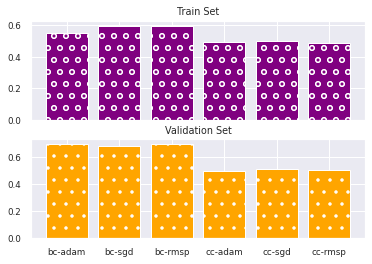

In [25]:
train_accuracies = []
val_accuracies = []

for hist in all_hist:
    hist_df = pd.DataFrame(hist.history) 
    train_accuracies.append(float(hist_df.tail(1)['accuracy']))
    val_accuracies.append(float(hist_df.tail(1)['val_accuracy']))

# 预测准确率直方图
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_title("Train Set")
ax1.bar(range(len(train_accuracies)), train_accuracies, color='purple', hatch='o')
ax2.set_title("Validation Set")
ax2.bar(range(len(val_accuracies)), val_accuracies, color='orange', hatch='.')
plt.xticks(range(6), ['bc-adam', 'bc-sgd', 'bc-rmsp', 'cc-adam', 'cc-sgd', 'cc-rmsp'])

# 最高预测准确率
best_train_accuracy = max(train_accuracies)
best_val_accuracy = max(val_accuracies)
print('\nBest train accuracy: ' + str(int(best_train_accuracy * 100)) + ' %.')
print('\nBest validation accuracy: ' + str(int(best_val_accuracy * 100)) + ' %.\n')

# 最优模型
best_model = all_models[np.argmax(val_accuracies)]

上图展示了不同模型的最终训练集和验证集准确率，使用交叉熵损失函数、Adam 优化器在本次训练取得了最高的准确率（*不同数据集划分可能对结果产生影响*），是本次训练的最佳模型。模型们在训练集和验证集的预测准确率最高分别可以达到 66% 和 70%。

在我们的这个模型中，包含的网络层和用到的 tricks 比较少，因此可以遍历得过来。不过由于一般深度学习实验，相比普通机器学习任务，时间较长，并且参数众多，每一次变参都会重新训练，因此调参技巧就显得尤为重要。尽管大部分的调参过程还是需要手动尝试，但是调参还是有一些技巧的，比如：

- 当在一定 epochs 内呈现收敛趋势时，不必跑更多个周期；
- 如果训练集和验证集准确率差很多，可能出现了欠拟合和过拟合，考虑调整步长；
- 有些参数可以使用经验数值，比如 dropout 的 0.3、0.5、0.7 ...；lr 的 0.1、0.01、0.001 ...；
- 可以用二分思维进行调参，找到准确率相对于该参数的极高值；
- 调参只是为了寻找合适的参数，而不是产出最终模型，可以在小数据集上进行预调参；
- 已经有一些对于自动调参的研究，比如变化的学习率和 sklearn 的 `GridSearch` 等等。

上述的参数主要是根据调参经验选择比较常用的参数。对于这个网络，你还可以尝试：

- 调整网络结构：
    - 增加更多的隐藏层；
    - 调整隐藏层的输出单元；
    - 调整 dropout 的大小；
- 调整模型训练的参数：
    - 用其他损失函数进行编译；
    - 用其他优化器进行编译；
    - 在优化器中尝试不同的训练步长；
    - 尝试不同的 metrics;
    - 调整批大小；
    - 增加 epochs。

#### 模型导出

接下来，我们将上面在验证集上表现最好的模型 `best_model` 导出。如果用户提供了测试集，我们期望可以直接加载出训练好的模型，这样可以减少训练的时间。

In [26]:
# 保存模型
best_model.save('best_model')

# 载入新模型
new_model = keras.models.load_model("best_model")

# 打印两个模型
print("Original model:", best_model)
print("Loaded model:", new_model)

W0923 02:40:53.504966 140231262725888 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Original model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f89dbafc2e8>
Loaded model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f88fc686e80>


这样，新模型就被导入了，我们将要测试数据输入模型就能得到预测结果了。我另取了一些生化指标作为自己的测试集，用最优模型进行了预测：

In [27]:
my = {
    'age': [22, 51, 50, 26, 22, 22, 80, 81, 22, 24],
    'gender': [2, 2, 1, 1, 2, 2, 1, 2, 2, 1],
    'height': [178, 180, 165, 160, 175, 175, 160, 175, 175, 175],
    'weight': [75, 90, 55, 50, 65, 90, 80, 90, 90, 60],
    'ap_hi': [110, 120, 100, 100, 100, 120, 130, 110, 100, 110],
    'ap_lo': [80, 90, 60, 70, 80, 100, 100, 80, 70, 90],
    'cholesterol': [2, 1, 1, 1, 1, 1, 2, 3, 1, 1],
    'gluc': [1, 1, 1, 1, 1, 2, 2, 1, 1, 1],
    'smoke': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'alco': [0, 1, 0, 1, 0, 1, 0, 1, 1, 0],
    'active': [1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
    }

my_cardio = pd.DataFrame(my, columns=[
    'age', 'gender', 'height', 'weight',
    'ap_hi', 'ap_lo', 'cholesterol',
    'gluc', 'smoke','alco', 'active',
])

my_cardio.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,22,2,178,75,110,80,2,1,0,0,1
1,51,2,180,90,120,90,1,1,0,1,1
2,50,1,165,55,100,60,1,1,0,0,1
3,26,1,160,50,100,70,1,1,0,1,1
4,22,2,175,65,100,80,1,1,0,0,0
5,22,2,175,90,120,100,1,2,1,1,0
6,80,1,160,80,130,100,2,2,0,0,0
7,81,2,175,90,110,80,3,1,0,1,0
8,22,2,175,90,100,70,1,1,0,1,1
9,24,1,175,60,110,90,1,1,0,0,0


In [28]:
for b in np.concatenate((best_model.predict(my_cardio) > 0.5) * 1).flat:
    if b == 1:
        print("患病")
    else: 
        print("不患病")

不患病
不患病
不患病
不患病
不患病
不患病
患病
不患病
不患病
不患病


你也可以尝试在下面的 cell 中输入你的各项指标，预测一下你患心血管疾病的概率。

In [29]:
your = {
    'age': [int(input("您的年龄："))],
    'gender': [int(input("您的性别（1-女，2-男）："))],
    'height': [int(input("您的身高（厘米）："))],
    'weight': [int(input("您的体重（千克）："))],
    'ap_hi': [int(input("您的血压（高）："))],
    'ap_lo': [int(input("您的血压（低）："))],
    'cholesterol': [int(input("您的胆固醇水平（1-正常，2-略高，3-过高）："))],
    'gluc': [int(input("您的血糖水平（1-正常，2-略高，3-过高）："))],
    'smoke': [int(input("您是否吸烟（0-否，1-是）："))],
    'alco': [int(input("您是否酗酒（0-否，1-是）："))],
    'active': [int(input("您是否经常活动（0-否，1-是）："))],
    }

your_cardio = pd.DataFrame(your, columns=[
    'age', 'gender', 'height', 'weight',
    'ap_hi', 'ap_lo', 'cholesterol',
    'gluc', 'smoke','alco', 'active',
])

您的年龄：33
您的性别（1-女，2-男）：2
您的身高（厘米）：177
您的体重（千克）：78
您的血压（高）：118
您的血压（低）：76
您的胆固醇水平（1-正常，2-略高，3-过高）：1
您的血糖水平（1-正常，2-略高，3-过高）：1
您是否吸烟（0-否，1-是）：0
您是否酗酒（0-否，1-是）：1
您是否经常活动（0-否，1-是）：1


In [30]:
print(f"您患心血管疾病的概率为：{str(round(100 * best_model.predict(your_cardio)[0][0], 2))} %。")
print("*结果仅供参考*")

您患心血管疾病的概率为：47.12 %。
*结果仅供参考*


## 结语

随着机器学习技术在医疗行业的广泛应用，我们进行了用深度学习进行心血管疾病预测的尝试。我们首先对 Kaggle 上的心血管疾病数据集进行了预处理，之后进行了数据可视化探究了不同特征的数值分布。我们用 Keras 构建了心血管疾病的预测模型并对其进行了训练。我们模型训练准确率可达 70% 左右。最终，我们将该模型序列化导出，以供下一次使用。